# Model selection

In [1]:
import numpy as np
import pandas as pd

from time import time

import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('bmh')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error
# Decision tree-based algoritms
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
# Other machine learning algorithms
from sklearn.neighbors import KNeighborsRegressor

## Load data

In [3]:
df = pd.read_csv("training_data.csv")
df.head()

,price,bedrooms,bathrooms,covered_area_m2,total_area_m2,comuna,neighborhood,balcony_area,has_balcony_yn
0,523546,1,1,50,60,Las Condes,Las Condes - Grupo 3,10,1
1,550000,1,1,30,30,Las Condes,Las Condes - Grupo 3,0,0
2,400000,1,1,37,37,Las Condes,Las Condes - Grupo 3,0,0
3,465375,1,1,48,51,Las Condes,Las Condes - Grupo 3,3,1
4,450000,1,1,45,45,Las Condes,Las Condes - Grupo 3,0,0


## Check data

In [4]:
df[['price', 'covered_area_m2', 'total_area_m2']].describe().astype('int')

,price,covered_area_m2,total_area_m2
count,17508,17508,17508
mean,556852,65,71
std,395099,42,47
min,175000,16,16
25%,300000,38,40
50%,420000,50,54
75%,650000,80,85
max,2966763,500,535


In [5]:
df['comuna'] = df['comuna'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17508 entries, 0 to 17507
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   price            17508 non-null  int64   
 1   bedrooms         17508 non-null  int64   
 2   bathrooms        17508 non-null  int64   
 3   covered_area_m2  17508 non-null  int64   
 4   total_area_m2    17508 non-null  int64   
 5   comuna           17508 non-null  category
 6   neighborhood     17508 non-null  category
 7   balcony_area     17508 non-null  int64   
 8   has_balcony_yn   17508 non-null  int64   
dtypes: category(2), int64(7)
memory usage: 995.1 KB


## Train machine learning models

In [7]:
SEED = 21

features_dict = {
    'dataset_01': ['bedrooms', 'bathrooms', 'covered_area_m2', 'comuna', 'neighborhood'],
    'dataset_02': ['bedrooms', 'bathrooms', 'total_area_m2', 'comuna', 'neighborhood'],
    'dataset_03': ['bedrooms', 'bathrooms', 'covered_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'],
    'dataset_04': ['bedrooms', 'bathrooms', 'total_area_m2', 'has_balcony_yn', 'comuna', 'neighborhood'],
    'dataset_05': ['bedrooms', 'bathrooms', 'covered_area_m2', 'balcony_area', 'comuna', 'neighborhood'],
    'dataset_06': ['bedrooms', 'bathrooms', 'total_area_m2', 'balcony_area', 'comuna', 'neighborhood']
}

tree_based_models = {
    # Decision tree-based algorithms
    'DecisionTree': DecisionTreeRegressor(random_state=SEED),
    'RandomForest': RandomForestRegressor(random_state=SEED, 
                                          n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=SEED),
    'Bagging': BaggingRegressor(random_state=SEED, 
                                n_jobs=-1),
    'ExtraTrees': ExtraTreesRegressor(random_state=SEED, 
                                      n_jobs=-1),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=SEED),
    'XGBoost': XGBRegressor(use_label_encoder=False, 
                            eval_metric='mae', 
                            objective='reg:squarederror', 
                            random_state=SEED, 
                            n_jobs=-1),
    'LightGBM': LGBMRegressor(random_state=SEED, 
                              n_jobs=-1),
    'CatBoost': CatBoostRegressor(random_seed=SEED, 
                                  silent=True)
}

other_models = {
    # Linear models
    'LinearRegression': LinearRegression(n_jobs=-1, 
                                         fit_intercept=True, 
                                         normalize=False),
    'HuberRegressor': HuberRegressor(fit_intercept=True, 
                                     max_iter=100000),  # default=100
    'PassiveAggressiveRegressor': PassiveAggressiveRegressor(random_state=SEED, 
                                                             early_stopping=False, 
                                                             fit_intercept=True, 
                                                             max_iter=100000), # default=1000
    
    # k-nearest neighbors
    'KNeighborsRegressor': KNeighborsRegressor(n_jobs=-1),
}

scalers_dict = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}

In [8]:
NUM_SEEDS = 3
results = []

for dataset_key in features_dict:
    # Define features and target
    features = features_dict[dataset_key]
    X = df[features]
    y = df['price']
    
    # Get dummy variables
    X = pd.get_dummies(X)
        
    # Train tree-base models
    for model_key in tree_based_models:     
        estimator = tree_based_models[model_key]
        
        for num in range(NUM_SEEDS):
            CV = KFold(n_splits=5, shuffle=True, random_state=num)
        
            # Evaluate model using cross validation
            start = time()
            scores = cross_val_score(estimator, 
                                     X, y, 
                                     scoring='neg_median_absolute_error', 
                                     cv=CV, 
                                     n_jobs=-1)
            end = time()
        
            row = []
            row.extend([
                dataset_key, 
                model_key, 
                num, 
                abs(scores.mean()), 
                end - start
            ]) 
            results.append(row)
        
    # Train models that need data scaling
    for model_key in other_models:
        estimator = other_models[model_key]
        
        for scaler_key in scalers_dict:
            scaler = scalers_dict[scaler_key]
            
            # define the pipeline
            steps = []
            steps.append(('scaler', scaler))
            steps.append(('estimator', estimator))
            pipeline = Pipeline(steps=steps)
            
            for num in range(NUM_SEEDS):
                CV = KFold(n_splits=5, shuffle=True, random_state=num)
                
                # Evaluate model using cross validation
                start = time()
                scores = cross_val_score(pipeline, 
                                         X, y, 
                                         scoring='neg_median_absolute_error', 
                                         cv=CV, 
                                         n_jobs=-1)
                end = time()
                
                row = []
                row.extend([
                    dataset_key, 
                    model_key + "_" + scaler_key, 
                    num,
                    abs(scores.mean()), 
                    end - start
                ]) 
                results.append(row)
        
# Create dataframe with results
df_columns = [
    'dataset',
    'model',
    'seed', 
    'avg_score',
    'training_time'
] 
results_df = pd.DataFrame(results, columns=df_columns)
results_df

,dataset,model,seed,avg_score,training_time
0,dataset_01,DecisionTree,0,41820.469444,1.856484
1,dataset_01,DecisionTree,1,41456.738158,0.984001
2,dataset_01,DecisionTree,2,41085.951717,0.359233
3,dataset_01,RandomForest,0,40341.327405,6.146338
4,dataset_01,RandomForest,1,40248.205500,6.382708
...,...,...,...,...,...
301,dataset_06,KNeighborsRegressor_MinMaxScaler,1,40800.000000,2.211996
302,dataset_06,KNeighborsRegressor_MinMaxScaler,2,41580.260000,2.318982
303,dataset_06,KNeighborsRegressor_StandardScaler,0,40992.280000,2.631851
304,dataset_06,KNeighborsRegressor_StandardScaler,1,40800.000000,2.270396


## Analyze results

In [9]:
# Total training time
results_df['training_time'].sum()

3953.8382925987244

In [10]:
# Average score for each model
avg_score_by_model = results_df.groupby('model')['avg_score'].mean().sort_values().astype('int')
avg_score_by_model

model
CatBoost                                     38524
RandomForest                                 39364
LightGBM                                     39456
Bagging                                      39844
ExtraTrees                                   39927
HistGradientBoosting                         39962
KNeighborsRegressor_MinMaxScaler             41476
DecisionTree                                 41485
KNeighborsRegressor_StandardScaler           41489
PassiveAggressiveRegressor_MinMaxScaler      41967
PassiveAggressiveRegressor_StandardScaler    42399
GradientBoosting                             42926
HuberRegressor_MinMaxScaler                  42936
XGBoost                                      43032
HuberRegressor_StandardScaler                43291
LinearRegression_MinMaxScaler                49392
LinearRegression_StandardScaler              50267
Name: avg_score, dtype: int32

In [11]:
# Average training time for each model
results_df.groupby('model')['training_time'].mean().sort_values()

model
LinearRegression_MinMaxScaler                  0.461120
DecisionTree                                   0.483702
LinearRegression_StandardScaler                0.546718
LightGBM                                       1.012959
Bagging                                        1.532899
KNeighborsRegressor_MinMaxScaler               1.927814
HuberRegressor_StandardScaler                  2.244214
KNeighborsRegressor_StandardScaler             2.466654
GradientBoosting                               3.378900
XGBoost                                        3.511432
PassiveAggressiveRegressor_StandardScaler      3.609028
HistGradientBoosting                           5.383410
HuberRegressor_MinMaxScaler                    7.034436
RandomForest                                   7.508630
ExtraTrees                                     8.095730
CatBoost                                       9.478603
PassiveAggressiveRegressor_MinMaxScaler      160.981436
Name: training_time, dtype: float64

In [14]:
# Top 20 average score for model and dataset combination
results_df.groupby(['model', 'dataset'])['avg_score'].mean().sort_values().astype('int').head(20)

model                 dataset   
CatBoost              dataset_05    38073
                      dataset_04    38128
                      dataset_06    38157
                      dataset_02    38508
RandomForest          dataset_05    38718
                      dataset_06    38793
CatBoost              dataset_03    38814
LightGBM              dataset_04    39128
                      dataset_05    39177
                      dataset_06    39183
                      dataset_02    39259
RandomForest          dataset_02    39309
Bagging               dataset_05    39364
HistGradientBoosting  dataset_06    39436
                      dataset_04    39461
ExtraTrees            dataset_05    39462
RandomForest          dataset_04    39466
CatBoost              dataset_01    39467
ExtraTrees            dataset_06    39509
Bagging               dataset_06    39595
Name: avg_score, dtype: int32

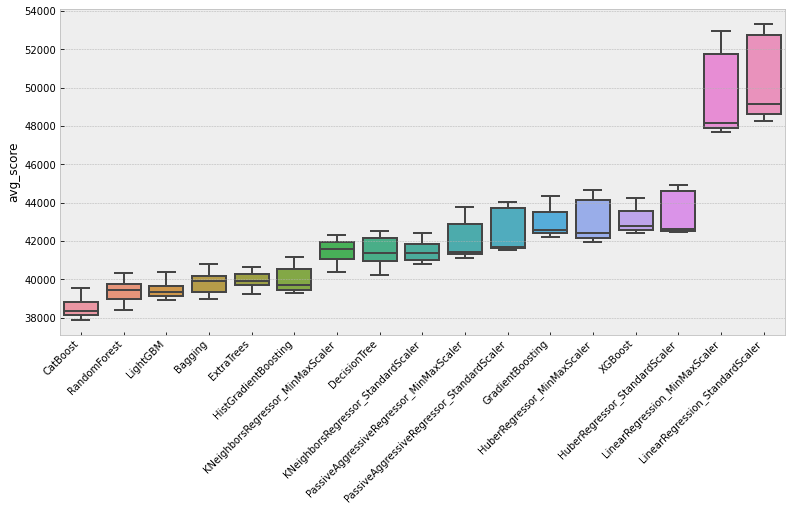

In [15]:
sorted_models = avg_score_by_model.index.tolist()

plt.figure(figsize=(13,6))
sb.boxplot(x='model', y='avg_score', data=results_df, order=sorted_models)
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
plt.show()